# Forecast Model Analysis
Trying some different models to predict weight.

In [1]:
import functions as sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
os.chdir('..')
from utils.weight_analysis import wana
analysis = wana('data/weight.csv')
os.chdir('forecast_model')

### Checking the Data

In [2]:
analysis.raw_df

,date,weight_lbs,exer,food,avg_7d
date,,,,,
2024-11-19,2024-11-19,160.4,1,5,160.00
2024-11-20,2024-11-20,159.2,1,6,160.00
2024-11-21,2024-11-21,159.0,0,5,160.03
2024-11-22,2024-11-22,159.2,1,6,159.86
2024-11-23,2024-11-23,159.0,0,5,159.66
...,...,...,...,...,...
2025-06-02,2025-06-02,157.2,1,3,155.54
2025-06-03,2025-06-03,156.6,1,4,NaN
2025-06-04,2025-06-04,157.2,1,4,NaN


In [3]:
analysis.df

,weight_lbs,exer,food,weight_lbs_avg_7d,food_avg_7d,exer_avg_7d,food_exercise_avg_7d
date,,,,,,,
2024-11-19,160.4,1,5,NaN,NaN,NaN,NaN
2024-11-20,159.2,1,6,NaN,NaN,NaN,NaN
2024-11-21,159.0,0,5,NaN,NaN,NaN,NaN
2024-11-22,159.2,1,6,NaN,NaN,NaN,NaN
2024-11-23,159.0,0,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-02,157.2,1,3,155.542857,0.666667,0.666667,0.666667
2025-06-03,156.6,1,4,155.714286,0.636364,0.833333,0.734848
2025-06-04,157.2,1,4,156.200000,0.515152,0.833333,0.674242


## ARIMA Model
SARIMAX(2,1,2) with food_exercise_avg_7d as x

In [4]:
no_miss = analysis.df.dropna()[['weight_lbs', 'food_exercise_avg_7d']]
no_miss

,weight_lbs,food_exercise_avg_7d
date,,
2024-11-25,158.8,0.651515
2024-11-26,159.0,0.651515
2024-11-27,159.0,0.553030
2024-11-28,157.0,0.651515
2024-11-29,161.0,0.590909
...,...,...
2025-06-02,157.2,0.666667
2025-06-03,156.6,0.734848
2025-06-04,157.2,0.674242


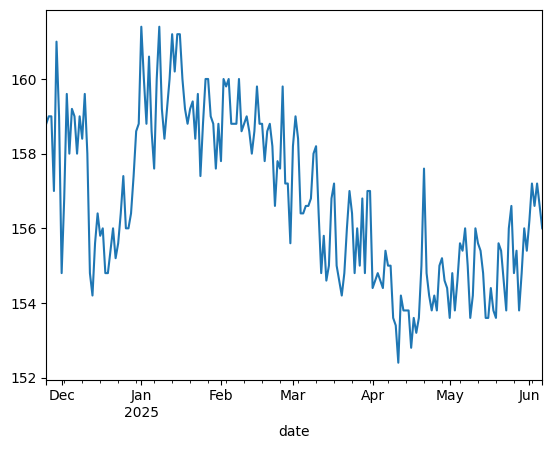

In [5]:
y = no_miss['weight_lbs']
x = no_miss['food_exercise_avg_7d']
y.plot()
plt.show()

In [6]:
sf.stationarity_test(y)

('Non-Stationarity', 'Non-Stationarity')

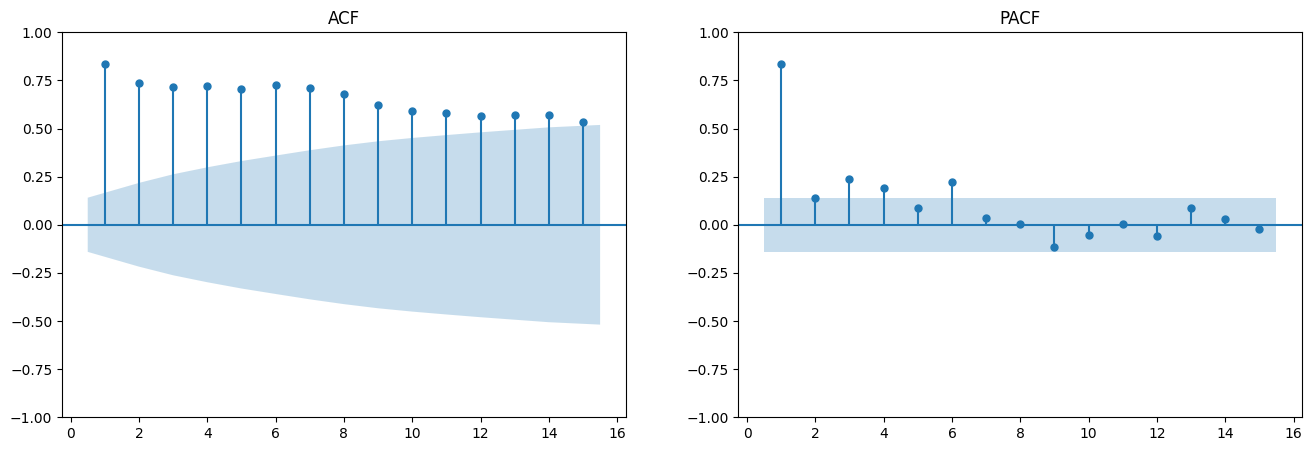

In [7]:
sf.all_ac(y)

/Users/danielferreira/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             weight_lbs   No. Observations:                  194
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -289.991
Date:                Fri, 06 Jun 2025   AIC                            591.983
Time:                        22:40:46   BIC                            611.559
Sample:                    11-25-2024   HQIC                           599.910
                         - 06-06-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
food_exercise_avg_7d    -1.9424      0.785     -2.473      0.013      -3.482      -0.403
ar.L1                    0.9043      0.320      2.825      0.005       0.277       1.532
ar.L2       

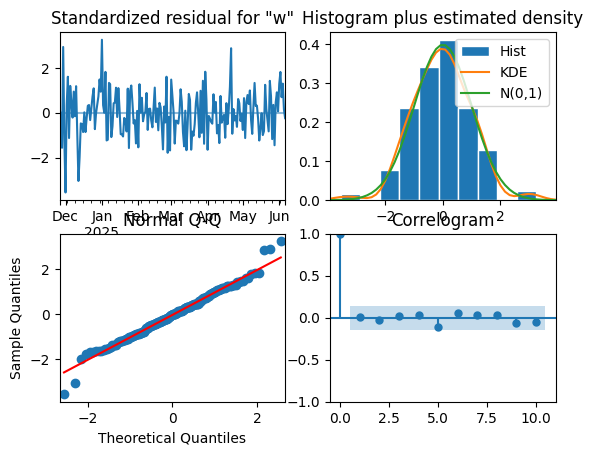

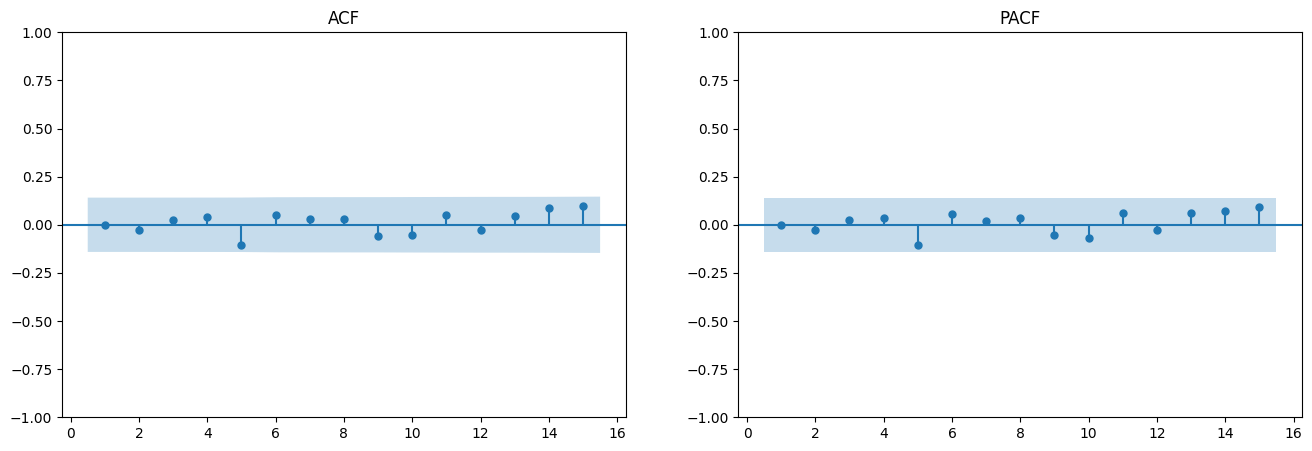

In [8]:
model1 = SARIMAX(y, order=(2,1,2), exog=x).fit(disp=False)
sf.diagnostic(model1)

In [9]:
future_steps = 14
x_bad = np.full(future_steps, 0.25)
x_good = np.full(future_steps, 0.75)
prediction_bad = model1.get_forecast(steps=future_steps, exog=x_bad).predicted_mean
prediction_good = model1.get_forecast(steps=future_steps, exog=x_good).predicted_mean

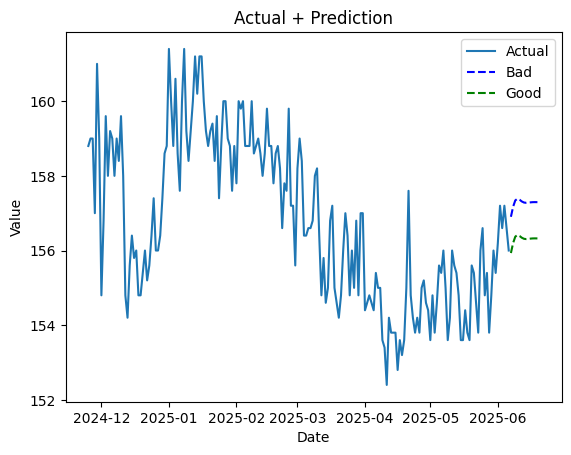

In [10]:
sf.compare_predictions(y,[prediction_bad,prediction_good],['Bad','Good'])

## Second Model: X has more info than past Y
I will use PLS, x are going to be combined in such a way the covariance between y and f(x)

In [26]:
df = analysis.df[['weight_lbs_avg_7d', 'exer', 'food']].dropna()
df

,weight_lbs_avg_7d,exer,food
date,,,
2024-11-25,159.228571,1,2
2024-11-26,159.028571,1,5
2024-11-27,159.000000,0,5
2024-11-28,158.714286,1,6
2024-11-29,158.971429,1,2
...,...,...,...
2025-06-02,155.542857,1,3
2025-06-03,155.714286,1,4
2025-06-04,156.200000,1,4


In [27]:
weekly_df = analysis.df.resample('W').agg({'weight_lbs_avg_7d': 'last','exer': 'sum','food': 'mean'})
weekly_df['y'] = weekly_df['weight_lbs_avg_7d'].diff()
weekly_df = weekly_df.dropna()
weekly_df


,weight_lbs_avg_7d,exer,food,y
date,,,,
2024-12-08,158.514286,5,5.000000,0.142857
2024-12-15,156.714286,5,5.428571,-1.800000
2024-12-22,155.428571,6,6.142857,-1.285714
2024-12-29,156.457143,5,3.571429,1.028571
2025-01-05,159.542857,7,1.857143,3.085714
2025-01-12,159.400000,6,2.857143,-0.142857
2025-01-19,160.257143,2,3.285714,0.857143
2025-01-26,158.971429,6,5.142857,-1.285714
2025-02-02,158.857143,1,4.142857,-0.114286


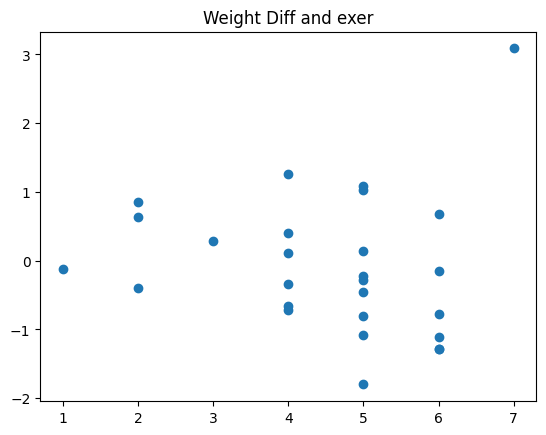

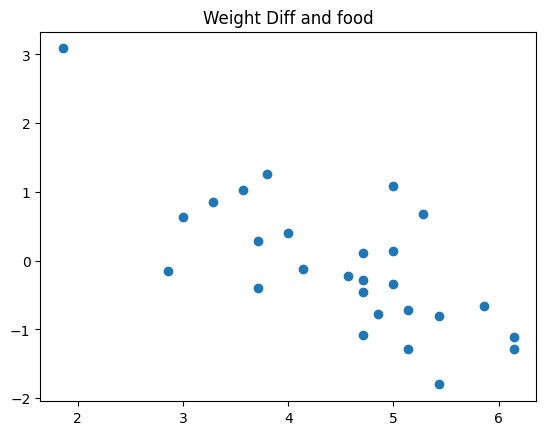

In [30]:
for x in ['exer', 'food']:
    plt.scatter(weekly_df[x],weekly_df['y'])
    plt.title(f'Weight Diff and {x}')
    plt.show()

In [ ]:
week = no_miss.resample('W').mean()[['weight_lbs', 'food_exercise_avg_7d']]

In [ ]:
plt.scatter(week['weight_lbs'], week['food_exercise_avg_7d'])

In [ ]:
import json
os.chdir('forecast_model')

model_params = {
    "params": model2.params.to_dict(),
    "order": (0, 1, 2),
    "exog_mean": x.mean(),
    "exog_std": x.std()
}

with open('model_parameters.json', 'w') as f:
    json.dump(model_params, f)

In [ ]:

with open('model_parameters.json', 'r') as f:
    model_params = json.load(f)

In [ ]:
model = SARIMAX(y, order=tuple(model_params["order"]), exog=x).fit()  


In [ ]:
model.params

In [ ]:
model.params = np.array(list(model_params["params"].values()))

In [ ]:
model.params

In [ ]:
forecast_1 = model.get_forecast(steps=future_steps, exog=x_bad).predicted_mean
forecast_2 = model.get_forecast(steps=future_steps, exog=x_good).predicted_mean

sf.compare_predictions(y,[forecast_1,forecast_2], ['Bad', 'Good'])

In [ ]:
model_params

In [ ]:
def predict_scenario(exog):
    model = SARIMAX(
        endog=dummy_endog,  # Dummy endog, as we only need the coefficients
        order=tuple(model_params["order"]),
        exog=exog
    )
    model.initialize_known(
        initial_state=np.zeros(model.k_states),
        initial_state_cov=np.eye(model.k_states)
    )
    model.update(model_params["params"])
    return model.simulate(model_params["params"], steps=future_steps, exog=exog)

# Predict for both scenarios
predictions_1 = predict_scenario(x_bad)
predictions_2 = predict_scenario(x_good)

In [ ]:
print(len(y))  # Length of the dependent variable
print(len(x))  # Length of the independent variable

In [ ]:

with open('model_parameters.json', 'r') as f:
    model_params = json.load(f)


future_dates = pd.date_range(start=max, periods=future_steps, freq="D")

# Create exogenous variables for both scenarios
x_scenario_1 = np.full(future_steps, 0.25)
x_scenario_2 = np.full(future_steps, 0.75)

# Standardize exogenous variables (if needed)
x_scenario_1 = (x_scenario_1 - model_params["exog_mean"]) / model_params["exog_std"]
x_scenario_2 = (x_scenario_2 - model_params["exog_mean"]) / model_params["exog_std"]

# Initialize SARIMAX model with loaded coefficients
def predict_scenario(exog):
    model = SARIMAX(
        endog=[0],  # Dummy endog, as we only need the coefficients
        order=tuple(model_params["order"]),
        exog=exog
    )
    model.initialize_known(
        initial_state=np.zeros(model.k_states),
        initial_state_cov=np.eye(model.k_states)
    )
    model.update(model_params["params"])
    return model.simulate(model_params["params"], steps=future_steps, exog=exog)

# Predict for both scenarios
predictions_1 = predict_scenario(x_scenario_1)
predictions_2 = predict_scenario(x_scenario_2)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions_1, label="Scenario 1 (x=0.25)", color="blue")
plt.plot(future_dates, predictions_2, label="Scenario 2 (x=0.75)", color="orange")
plt.title("SARIMAX Predictions for Two Scenarios")
plt.xlabel("Date")
plt.ylabel("Weight (lbs)")
plt.legend()
plt.grid()
plt.show()